# Gaussian Mixture Model (NIR beers dataset)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local utility functions and classes

In [2]:
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Model configuration

In [3]:
# model mode
model_mode      = 'training'
#model_mode      = 'predict'

# data filenames
#data_filename   = '../../data/beers/NIR_beers.csv'
data_filename   = '../../code/test/dummy_data_e.csv'
trace_filename  = './traces/trace_beers_nir_linear_class'

## Load dataset, import and plot samples

In [4]:
# init dataset object
data_obj = Data(data_filename, 'label', -1)   
data_obj.data.head(5)
data = data_obj.data
data.head(5)

,200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,209.0,...,392.0,393.0,394.0,395.0,396.0,397.0,398.0,399.0,400.0,label
27,6.881024,6.947529,6.666373,6.861985,6.955925,6.717851,6.787064,6.698755,6.805998,6.847270,...,7.001415,7.046166,6.966045,6.961040,6.755324,6.848361,6.872431,6.625473,6.784965,A
15,5.192037,5.090180,5.131452,5.237587,5.321174,5.257083,5.120364,5.124305,5.244533,5.244522,...,5.522784,5.336443,5.466826,5.199970,5.247703,5.235780,5.136867,5.055178,5.590475,A
23,1.837926,2.042556,2.153756,1.980209,2.017546,1.970884,2.111093,1.980560,2.053374,1.829836,...,2.121654,2.251827,2.060904,2.208998,2.061760,2.115008,2.124988,1.977369,2.103163,B
17,7.570414,7.499118,7.523942,7.518289,7.555801,7.727666,7.539949,7.450779,7.566512,7.724230,...,7.887063,7.643550,7.625270,7.496501,7.782103,7.542346,7.764543,7.573669,7.570093,A
8,7.687658,7.716975,7.648924,7.782565,7.673262,7.678095,7.674769,7.738919,7.802392,7.658024,...,7.957942,7.849725,7.793201,7.811192,7.626163,7.546779,7.609812,7.688417,7.682063,A


A: blue
B: red


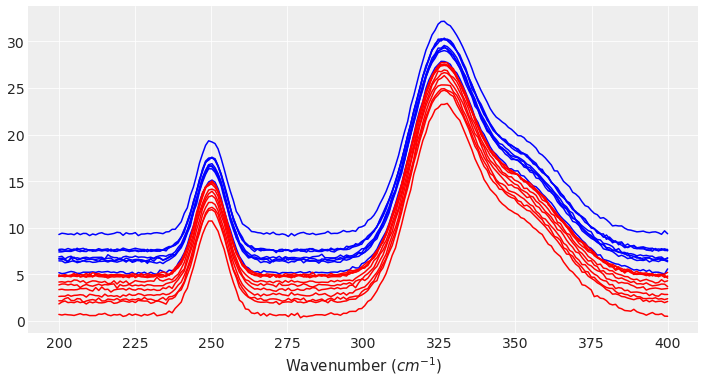

In [5]:
# list of class labels
class_labels = data_obj.get_class_labels()

# number of classes
nclasses = len(class_labels)

# plot dataframe
utl.plot_data(data_obj, 20)

In [6]:
# number of samples from each class
print(data_obj.data[data_obj.label_column].value_counts())

B    15
A    15
Name: label, dtype: int64


In [7]:
# generate training and test sets
train_data, test_data = train_test_split(data_obj.data, train_size=0.5, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [8]:
test_data.shape

(15, 201)

In [9]:
train_data.shape

(15, 201)

In [10]:
train_data.head()

,200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,209.0,...,392.0,393.0,394.0,395.0,396.0,397.0,398.0,399.0,400.0,label
0,4.638270,4.652014,4.660568,4.746120,4.628671,4.707128,4.686832,4.666593,4.740010,4.949567,...,4.985220,5.138067,4.964579,4.833286,4.973132,4.738454,4.835691,4.837651,4.608412,B
1,5.192037,5.090180,5.131452,5.237587,5.321174,5.257083,5.120364,5.124305,5.244533,5.244522,...,5.522784,5.336443,5.466826,5.199970,5.247703,5.235780,5.136867,5.055178,5.590475,A
2,1.837926,2.042556,2.153756,1.980209,2.017546,1.970884,2.111093,1.980560,2.053374,1.829836,...,2.121654,2.251827,2.060904,2.208998,2.061760,2.115008,2.124988,1.977369,2.103163,B
3,5.692861,5.673563,5.813472,5.549013,5.769599,5.671705,5.641789,5.831923,5.758980,5.927249,...,5.764981,5.920578,6.000669,5.804996,5.694195,5.796056,5.675700,5.766760,5.767358,A
4,7.570414,7.499118,7.523942,7.518289,7.555801,7.727666,7.539949,7.450779,7.566512,7.724230,...,7.887063,7.643550,7.625270,7.496501,7.782103,7.542346,7.764543,7.573669,7.570093,A


# Model definition
The following model is assumed:

\begin{equation}
\large A_{m} \sim \text{U} (0, max(Y)) \\
\large \mu_{m} \sim \mathcal{N}(\mu_{m}, 50) \\
\large \sigma_{m} \sim |\mathcal{N}(0, 100)| \\
\large \epsilon \sim |\mathcal{N}(0, 1)| \\
\large \theta = \sum\limits_{m=1}^M [A_m \cdot e^{-\frac{(x_n-\mu_m)^2}{2\cdot\sigma_m^2}}] + a_0 + a_1 \cdot x_n \\
\large y \sim \mathcal{N}(\theta, \epsilon)
\end{equation}

In [11]:
# 1D array of X values
len_x = len(train_data.columns[:data_obj.non_data_columns])
x_val = np.array(train_data.columns[:data_obj.non_data_columns], dtype='float32').reshape(len_x,1)

# 1D column vector containing class codes
len_y = len(train_data)
Y = np.array(pd.Categorical(train_data[data_obj.label_column]).codes, dtype='int').reshape(len_y,1)

x_n = train_data.columns[:data_obj.non_data_columns]
x_s = train_data[x_n].values

In [12]:
npeaks = 3
    
with pm.Model() as model:
    amp = pm.Uniform('amp', 0, x_s.max(), shape=(nclasses,npeaks))
    mu = pm.Normal('mu', mu=np.linspace(x_val.min(), x_val.max(), npeaks), sd=50, 
                   shape=(nclasses,npeaks), transform=pm.distributions.transforms.ordered)
    sigma = pm.HalfNormal('sigma', sd=100, shape=(nclasses,npeaks))
        
    #a_0 = pm.Normal('a_0', mu=0, sd=10, shape=(nclasses,1))
    a_0 = pm.Normal('a_0', mu=0, sd=5, shape=(len(x_s),1))
    
    print("amp  : ", amp.tag.test_value.shape)
    print("mu   : ", mu.tag.test_value.shape)
    print("sigma: ", sigma.tag.test_value.shape)
    print("a_0  : ", a_0.tag.test_value.shape)
    
    #y_a = pm.Deterministic('y_a', (amp[0] * np.exp(-(x_val - mu[0])**2/(2 * sigma[0]**2))).sum(axis=1) 
    #                       + a_0[0]).reshape((1,len(x_val)))
    #y_b = pm.Deterministic('y_b', (amp[1] * np.exp(-(x_val - mu[1])**2/(2 * sigma[1]**2))).sum(axis=1) 
    #                       + a_0[1]).reshape((1,len(x_val)))
    
    y_a = pm.Deterministic('y_a', (amp[0] * np.exp(-(x_val - mu[0])**2/(2 * sigma[0]**2))).sum(axis=1) + a_0)
    y_b = pm.Deterministic('y_b', (amp[1] * np.exp(-(x_val - mu[1])**2/(2 * sigma[1]**2))).sum(axis=1) + a_0)
    
    print("x_val: ", x_val.shape)
    print("y_a  : ", y_a.tag.test_value.shape)
    print("y_b  : ", y_b.tag.test_value.shape)
    
    # labels 0 or 1 (observed from the data)
    theta = pm.Beta('theta', 1., 1.)
    label = pm.Bernoulli('label', p=theta, observed=Y)
    
    print("Y     :", Y.shape)
    print("label :", label.tag.test_value.shape)
    
    # switch to spectrum class A/B depending on label
    y_obs = pm.math.switch(pm.math.eq(label, 1), y_a, y_b)
       
    sigma_e = pm.Gamma('sigma_e', alpha=1., beta=1.)
    epsilon = pm.HalfNormal('epsilon', sd=sigma_e)
    
    print("epsilon:", epsilon.tag.test_value.shape)
    
    y_pred = pm.Normal('y_pred', mu=y_obs, sd=epsilon, observed=x_s)
    
    print("y_obs :", y_obs.tag.test_value.shape)
    print("x_s   :", x_s.shape)
    print("y_pred:", y_pred.tag.test_value.shape)

    if model_mode == 'training':
        #trace = pm.sample(2000, init='adapt_diag', tune=1000, random_seed=42)
        trace = pm.sample(2000, init='adapt_diag', tune=1000)
    else:
        # load traces from trained model
        trace = pm.backends.text.load(trace_filename)

amp  :  (2, 3)
mu   :  (2, 3)
sigma:  (2, 3)
a_0  :  (15, 1)
x_val:  (200, 1)
y_a  :  (15, 200)
y_b  :  (15, 200)
Y     : (15, 1)
label : (15, 1)
epsilon: ()


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


y_obs : (15, 200)
x_s   : (15, 200)
y_pred: (15, 200)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, theta, a_0, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [02:50<00:00, 35.27draws/s] 


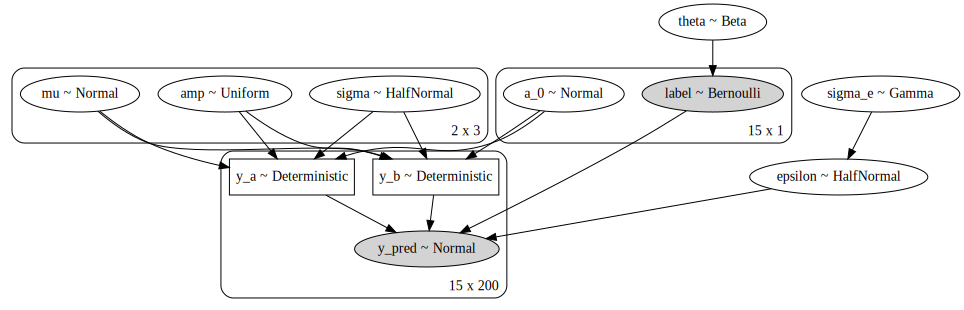

In [13]:
pm.model_to_graphviz(model)

In [ ]:
npeaks = 3
    
with pm.Model() as model_shared:
    
    Y_shared = pm.Data('Y_shared', Y)
    
    amp = pm.Uniform('amp', 0, x_s.max(), shape=(nclasses,npeaks))
    mu = pm.Normal('mu', mu=np.linspace(x_val.min(), x_val.max(), npeaks), sd=50, 
                   shape=(nclasses,npeaks), transform=pm.distributions.transforms.ordered)
    sigma = pm.HalfNormal('sigma', sd=100, shape=(nclasses,npeaks))
        
    a_0 = pm.Normal('a_0', mu=0, sd=10, shape=(nclasses,1))
    
    print("amp  : ", amp.tag.test_value.shape)
    print("mu   : ", mu.tag.test_value.shape)
    print("sigma: ", sigma.tag.test_value.shape)
    print("a_0  : ", a_0.tag.test_value.shape)
    
    y_a = pm.Deterministic('y_a', (amp[0] * np.exp(-(x_val - mu[0])**2/(2 * sigma[0]**2))).sum(axis=1) 
                           + a_0[0]).reshape((1,len(x_val)))
    y_b = pm.Deterministic('y_b', (amp[1] * np.exp(-(x_val - mu[1])**2/(2 * sigma[1]**2))).sum(axis=1) 
                           + a_0[1]).reshape((1,len(x_val)))
    
    print("x_val: ", x_val.shape)
    print("y_a  : ", y_a.tag.test_value.shape)
    print("y_b  : ", y_b.tag.test_value.shape)
    
    # labels 0 or 1 (observed from the data)
    theta = pm.Beta('theta', 1., 1.)
    label = pm.Bernoulli('label', p=theta, observed=Y_shared)
    
    print("Y     :", Y.shape)
    print("label :", label.tag.test_value.shape)
    
    # switch to spectrum class A/B depending on label
    y_obs = pm.math.switch(pm.math.eq(label, 1), y_a, y_b)
       
    sigma_e = pm.Gamma('sigma_e', alpha=1., beta=1.)
    epsilon = pm.HalfNormal('epsilon', sd=sigma_e)
    
    print("epsilon:", epsilon.tag.test_value.shape)
    
    y_pred = pm.Normal('y_pred', mu=y_obs, sd=epsilon, observed=x_s)
    
    print("y_obs :", y_obs.tag.test_value.shape)
    print("x_s   :", x_s.shape)
    print("y_pred:", y_pred.tag.test_value.shape)

    if model_mode == 'training':
        #trace = pm.sample(2000, init='adapt_diag', tune=1000, random_seed=42)
        #trace = pm.sample(2000, init='adapt_diag', tune=1000)
        True
    else:
        # load traces from trained model
        trace = pm.backends.text.load(trace_filename)

In [ ]:
#pm.model_to_graphviz(model_shared)

# Model evaluation

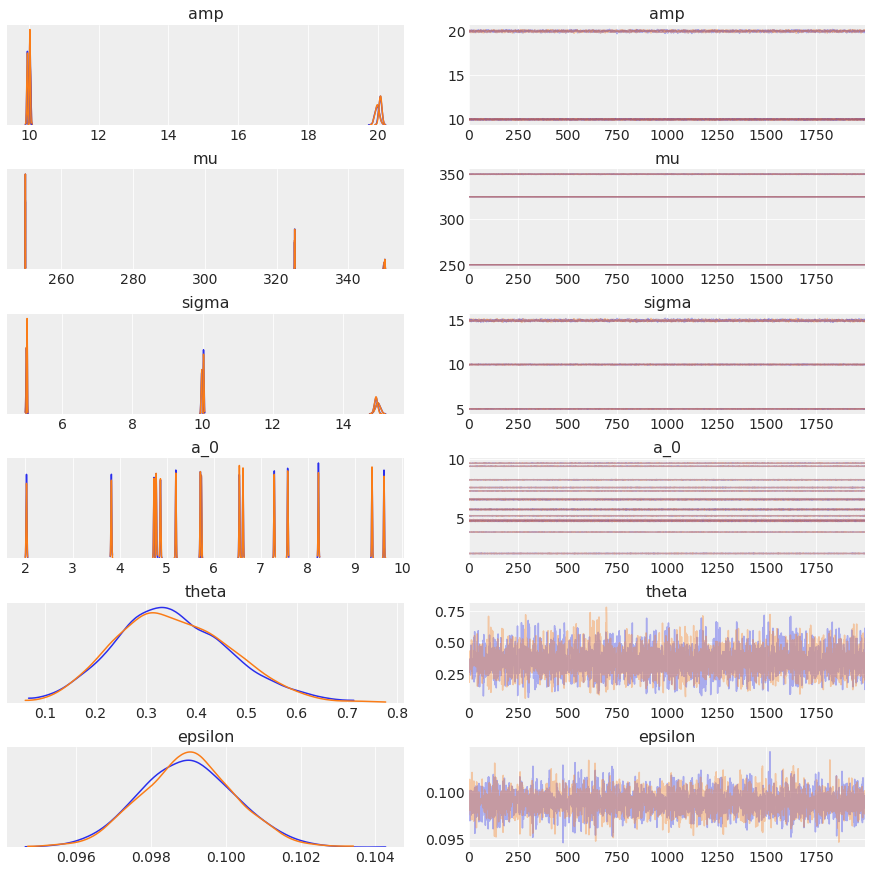

In [14]:
varnames = ['amp', 'mu', 'sigma', 'a_0', 'theta', 'epsilon']
az.plot_trace(trace, varnames, compact=True);

In [15]:
#az.plot_posterior(trace, varnames);

In [16]:
ppc_mm = pm.sample_posterior_predictive(trace, samples=500, model=model)

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 286.31it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


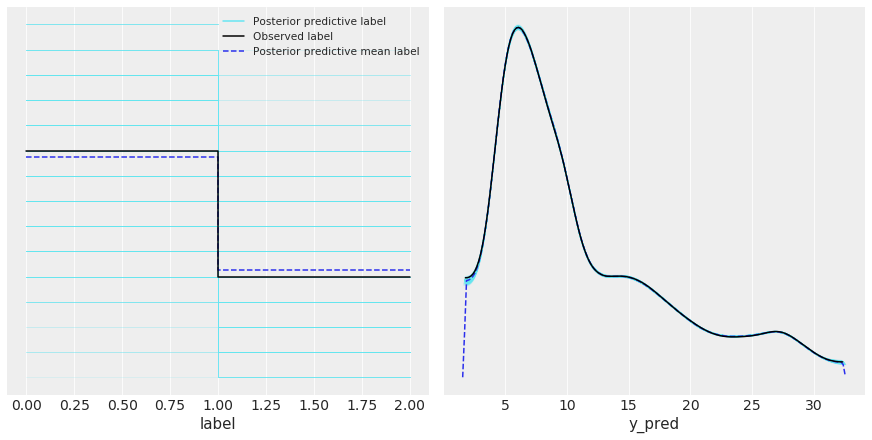

In [17]:
data_ppc = az.from_pymc3(trace=trace, posterior_predictive=ppc_mm)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

## Compare distribution of data and posterior samples

In [18]:
x_val = x_val.reshape(len(x_val),)

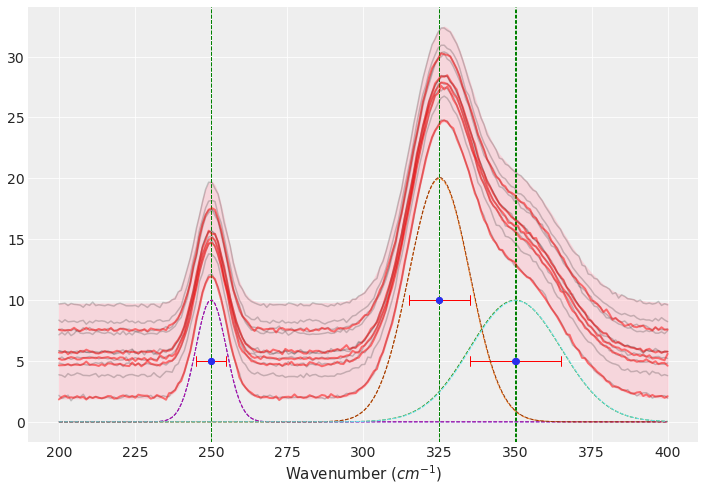

In [36]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set(xlabel='Wavenumber ($cm^{-1}$)')

# plot samples from the posterior
sp = ppc_mm['y_pred']
for i in range(10):
    plt.plot(x_val, sp[i,i,:], '-', color="black", alpha=.2)

# plot 94% HPD interval
az.plot_hpd(x_val, ppc_mm['y_pred'], smooth=False, credible_interval=0.98, color='pink')
    
# plot mixture components 
A = trace['amp'].mean(axis=0).flatten()
M = trace['mu'].mean(axis=0).flatten()
S = trace['sigma'].mean(axis=0).flatten()
for j in range(len(A)):
    Y = A[j] * np.exp(-(x_val - M[j])**2/(2 * S[j]**2))
    plt.plot(x_val, Y, '--', linewidth=1)
    plt.axvline(M[j], linestyle='--', linewidth=1, color='g')
    plt.errorbar(x=M[j], y=.5*A[j], xerr=S[j], fmt='o', 
                     ecolor='r', elinewidth=1, capsize=5, capthick=1)
    
# plot samples from the dataset
for i in range(5):
    y_val = train_data.values[i]
    plt.plot(x_val, y_val[:data_obj.non_data_columns], '-', color="red", alpha=.5, linewidth=2)

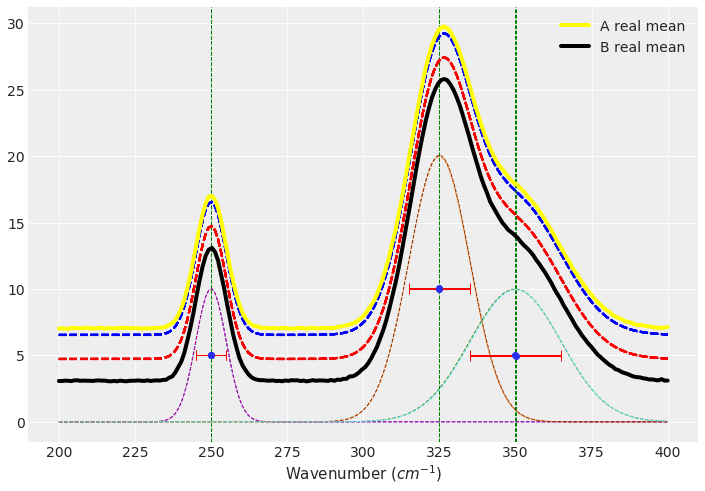

In [25]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set(xlabel='Wavenumber ($cm^{-1}$)')

# plot mixture components 
A = trace['amp'].mean(axis=0).flatten()
M = trace['mu'].mean(axis=0).flatten()
S = trace['sigma'].mean(axis=0).flatten()
for j in range(len(A)):
    Y = A[j] * np.exp(-(x_val - M[j])**2/(2 * S[j]**2))
    plt.plot(x_val, Y, '--', linewidth=1)
    plt.axvline(M[j], linestyle='--', linewidth=1, color='g')
    plt.errorbar(x=M[j], y=.5*A[j], xerr=S[j], fmt='o', 
                     ecolor='r', elinewidth=1, capsize=5, capthick=1)

# plot samples from the posterior
st_a = trace['y_a']
st_b = trace['y_b']
for i in range(50):
    plt.plot(x_val, st_a[-i,0,:], '--', color="red", alpha=.2, linewidth=2)
    plt.plot(x_val, st_b[-i,10,:], '--', color="blue", alpha=.2, linewidth=2)
    
# plot the mean of the real data
class_labels = data_obj.get_class_labels()
df = [ data_obj.data.loc[data_obj.data[data_obj.label_column] == class_labels[k]]
       for k in range(len(class_labels)) ]
for z in range(len(df)):
    cls_label = str(class_labels[z]) + " real mean"
    plt.plot(x_val, df[z].iloc[:,:data_obj.non_data_columns].mean(), '-', color=utl.get_color_mean(z),
         label=cls_label, linewidth=4)
        
plt.legend(loc='best');

In [26]:
az.r2_score(x_s, ppc_mm['y_pred'])

r2        0.999792
r2_std    0.000014
dtype: float64

In [27]:
varnames = ['amp', 'mu', 'sigma', 'a_0', 'epsilon']
az.summary(trace, varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"amp[0,0]",10.027,0.020,9.993,10.066,0.000,0.000,5704.0,5703.0,5703.0,3249.0,1.0
"amp[0,1]",19.988,0.064,19.869,20.106,0.002,0.001,1500.0,1500.0,1500.0,2473.0,1.0
"amp[0,2]",9.991,0.025,9.942,10.037,0.001,0.000,1734.0,1734.0,1746.0,2199.0,1.0
"amp[1,0]",10.026,0.013,10.002,10.051,0.000,0.000,5737.0,5736.0,5736.0,3455.0,1.0
"amp[1,1]",20.080,0.043,19.999,20.158,0.001,0.001,1516.0,1516.0,1516.0,2333.0,1.0
"amp[1,2]",9.954,0.017,9.922,9.985,0.000,0.000,1557.0,1557.0,1555.0,2727.0,1.0
"mu[0,0]",249.990,0.011,249.970,250.009,0.000,0.000,9391.0,9391.0,9387.0,2802.0,1.0
"mu[0,1]",325.005,0.026,324.953,325.050,0.001,0.000,1548.0,1548.0,1553.0,2294.0,1.0
"mu[0,2]",349.940,0.106,349.746,350.140,0.003,0.002,1394.0,1394.0,1409.0,2034.0,1.0
"mu[1,0]",249.997,0.007,249.983,250.011,0.000,0.000,7912.0,7912.0,7945.0,2928.0,1.0


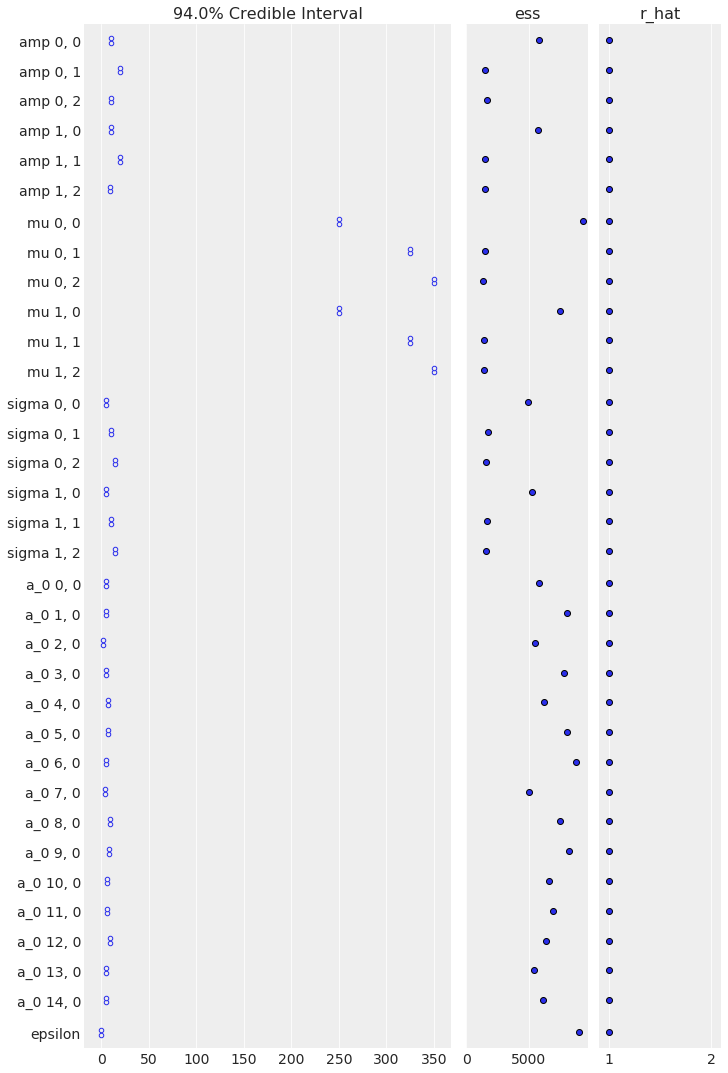

In [28]:
az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);

## Save results

In [ ]:
if model_mode == 'training':
    # save inference results
    pm.backends.text.dump(trace_filename, trace)